In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf 
import cv2
import shutil
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, CategoricalAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from keras.layers import BatchNormalization
from keras import regularizers
from tensorflow.keras.regularizers import l2
import imghdr
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

C:\Users\jason\AppData\Local\Temp\ipykernel_16960\3266627147.py:21: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [5]:
data_dir = 'data1'
problem_dir = 'problem_images'

os.makedirs(problem_dir, exist_ok=True)

# Loop through all images, moving problematic ones to the problem_images folder
for image_class in os.listdir(data_dir): 
    class_dir = os.path.join(data_dir, image_class)
    
    for image in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image)
        
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            
            # Check if the image extension is in the list of allowed extensions
            if tip not in image_exts: 
                print(f'Image not in ext list: {image_path}')
                shutil.move(image_path, os.path.join(problem_dir, image))  # Move file
        except Exception as e: 
            print(f'Issue with image: {image_path}, error: {e}')
            shutil.move(image_path, os.path.join(problem_dir, image))

In [6]:
data = tf.keras.utils.image_dataset_from_directory('data1') # builds image dataset for you

Found 2020 files belonging to 5 classes.


In [7]:
data_iterator = data.as_numpy_iterator() #allow us access to our generator from pipeline

In [11]:
batch = data_iterator.next()

In [12]:
batch[0].shape

(32, 256, 256, 3)

In [13]:
batch[1]

array([4, 3, 4, 4, 2, 4, 4, 3, 1, 1, 3, 4, 3, 2, 3, 4, 2, 2, 1, 4, 3, 2,
       4, 4, 4, 1, 0, 4, 4, 0, 2, 3])

In [14]:
data.class_names

['Brown Sugar Pic', 'Classic Pic', 'Mango Pic', 'Strawberry Pic', 'Taro Pic']

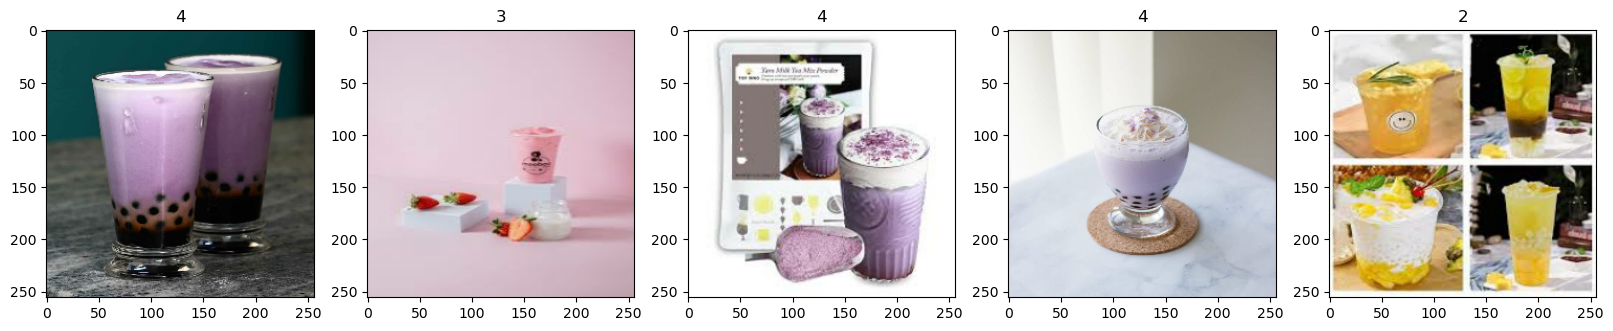

In [15]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [16]:
data = data.map(lambda x,y: (x/255, y))

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.05),
])

In [18]:
len(data)

64

In [19]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [20]:
def preprocess_data(image, label):
    label = tf.cast(label, tf.int32)  # Ensure label is in integer format
    label = tf.one_hot(label, depth=5)  # Assuming 5 classes
    return image, label

In [21]:
#data partitioning 
#takes first train, skips train batch, takes val_size batch, skips both train and val batch and takes test_size batch for test
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [22]:
# Apply one-hot encoding to labels
train = train.map(preprocess_data)
val = val.map(preprocess_data)
test = test.map(preprocess_data)

In [23]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

In [24]:
model = Sequential()
model.add(layers.Input(shape=(256, 256, 3))) 
model.add(data_augmentation)


model.add(Conv2D(16, (3,3), padding = 'same', activation='relu', kernel_regularizer=l2(0.01))) #input of 256 by 256 by 3 represents each image has a pixel of 256x256 with 3 colors RGB
model.add(MaxPooling2D()) 
model.add(layers.BatchNormalization())

model.add(Conv2D(32, (3,3), padding = 'same', activation='relu', kernel_regularizer=l2(0.01))) #32 filters, 3 by 3 block changed 32-64
model.add(MaxPooling2D())
model.add(layers.BatchNormalization())

model.add(Conv2D(64, (3,3), padding = 'same', activation='relu', kernel_regularizer=l2(0.01))) #changed from 32-64
model.add(MaxPooling2D())
model.add(layers.BatchNormalization())  
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.BatchNormalization())  

model.add(Dense(5, activation='softmax')) 

In [25]:
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       4,194,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,218,981 (16.09 MB)

 Trainable params: 4,218,629 (16.09 MB)

 Non-trainable params: 352 (1.38 KB)

In [27]:
logdir = 'logs'

In [28]:
#logs progress
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [30]:
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback,lr_scheduler, early_stopping])

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 620ms/step - accuracy: 0.4915 - loss: 4.1148 - val_accuracy: 0.1719 - val_loss: 4.4177 - learning_rate: 0.0010
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 618ms/step - accuracy: 0.7734 - loss: 2.9805 - val_accuracy: 0.2943 - val_loss: 4.0428 - learning_rate: 0.0010
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 628ms/step - accuracy: 0.7949 - loss: 2.1701 - val_accuracy: 0.2448 - val_loss: 3.3325 - learning_rate: 0.0010
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 612ms/step - accuracy: 0.7898 - loss: 1.7565 - val_accuracy: 0.2292 - val_loss: 3.0891 - learning_rate: 0.0010
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 629ms/step - accuracy: 0.8374 - loss: 1.5180 - val_accuracy: 0.3125 - val_loss: 3.0617 - learning_rate: 0.0010
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 612ms/step - accuracy: 0.8426 - loss: 1.3682 - val_accuracy: 0.3307 - val_loss: 2.7463 - learning_rate: 0.0010
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 577ms/step - accuracy: 0.8061 - loss: 1.

In [54]:
hist.history

{'accuracy': [0.6072443127632141,
  0.7727272510528564,
  0.7911931872367859,
  0.7855113744735718,
  0.8188920617103577,
  0.8366477489471436,
  0.8053977489471436,
  0.8132102489471436,
  0.8274147510528564,
  0.8259943127632141,
  0.8295454382896423,
  0.8380681872367859,
  0.8394886255264282,
  0.8451704382896423,
  0.8373579382896423,
  0.859375,
  0.8366477489471436,
  0.8558238744735718,
  0.8884943127632141,
  0.9012784361839294,
  0.9098011255264282,
  0.9105113744735718,
  0.9147727489471436,
  0.9240056872367859,
  0.9446022510528564,
  0.9360795617103577,
  0.9289772510528564,
  0.9268465638160706,
  0.9247159361839294,
  0.9339488744735718],
 'loss': [3.8455350399017334,
  2.7708187103271484,
  2.054180860519409,
  1.7183761596679688,
  1.5083842277526855,
  1.3706841468811035,
  1.3572949171066284,
  1.2921797037124634,
  1.2564431428909302,
  1.210556149482727,
  1.1915183067321777,
  1.1117310523986816,
  1.0940725803375244,
  1.0961676836013794,
  1.066786766052246,
  

In [56]:
#model.save_weights("boba.weights.h5") 
#new_model = create_same_architecture_model()
#new_model.load_weights("boba.weights.h5") 

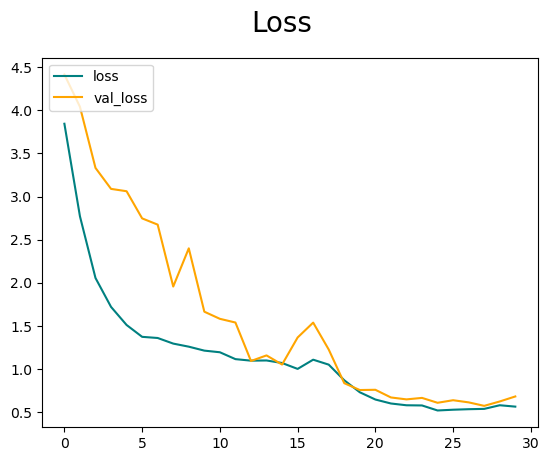

In [58]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

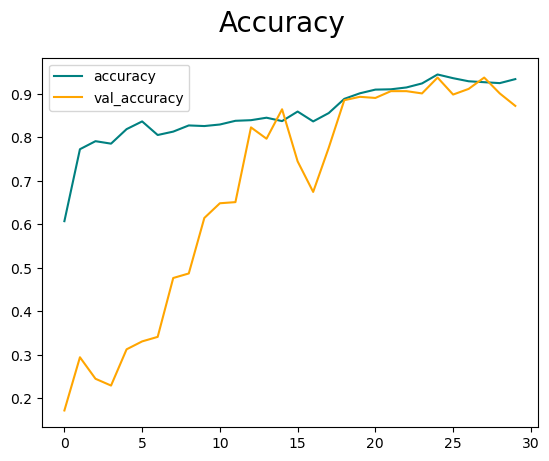

In [59]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [62]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

In [64]:
#testing out batch in test
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


In [65]:
print(f'Precision: {precision.result().numpy():.2f}, Recall: {recall.result().numpy():.2f}, Accuracy: {accuracy.result().numpy():.2f}')

Precision: 0.93, Recall: 0.91, Accuracy: 0.92


In [66]:
def classify_tea(image_path, model):
    img = cv2.imread(image_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    resized_img = tf.image.resize(img, (256, 256))

    normalized_img = resized_img / 255.0

    input_img = np.expand_dims(normalized_img, axis=0)

    yhat = model.predict(input_img)

    prediction = np.argmax(yhat, axis=1)[0]

    if prediction == 0: 
        print('This is a Brown Sugar Milk Tea')
    elif prediction == 1:
        print('This is a Classic Milk Tea')
    elif prediction == 2:
        print('This is a Mango Milk Tea')
    elif prediction == 3:
        print('This is a Strawberry Milk Tea')
    elif prediction == 4:
        print('This is a Taro Milk Tea')

In [67]:
classify_tea('brownsugar_test.jpg', model)
classify_tea('classic_test.jpg', model)
classify_tea('mango_test.jpg', model)
classify_tea('strawberry_test.jpg', model)
classify_tea('taro_test.jpeg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
This is a Brown Sugar Milk Tea
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
This is a Classic Milk Tea
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
This is a Mango Milk Tea
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
This is a Strawberry Milk Tea
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
This is a Taro Milk Tea
